## The SEIR model

The SEIR model of epidemiology partitions the population into three compartments: susceptibles, S, who can catch the disease; exposed, E, that has caught the infection but is not infectious;  infectives, I, who have already caught the disease and infect susceptibles; and recovered individuals, R. Since the disease is assumed not to be fatal, the sum $N=S+I+R$ remains constant. The rate at which the susceptibles get infected is 
$$
\lambda(t) = \frac{\beta I}{N}
$$
where the parameter $\beta$ is the probability of infection on contact. The infected individuals recover from the disease at a rate $\gamma$. Then, the ordinary differential equations of the SIR model are

\begin{align}
\dot S &= -\lambda(t)S \\
\dot E &= \lambda(t)S - \gamma_E E \\
\dot I &= \gamma_E E - \gamma I \\
\dot R &= \gamma I 
\end{align}

Here $ 1/\zeta$ can be interpreted as the average incubation period. This example integrates the above equations to obtain what is called the **epidemic curve**: a plot of the number of susceptibles and infectives as a function of time. 

------------------------------------------------------------------------------------------------------------------------------

#### After creating/cloning a new environment, with all the dependencies, either using conda or from ArcGIS Pro. 
#### (As per the instructions in the Readme.md)
#### Proceed with this notebook.

------------------------------------------------------------------------------------------------------------------------------

**Model B: single lockdown ver. 2.0 with SEIR Model**

---

* Checking Env.

In [ ]:
#forked from Rajesh Singh's work, related to Pyross Lib.
import sys
sys.executable

---

* Importing all req. libraries.

In [1]:
%matplotlib inline                  
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt     # optional for notebook visualization.

# imports for AGOL publishing
from arcgis.gis import GIS

---

* Loading & defining model parameters:

In [2]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [3]:
# contact matrices
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)

# matrix of total contacts
C=CH+CW+CS+CO

In [5]:
# epidemic parameters
beta  = 0.0315          # infection rate 
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
gE    = 1/4
alpha = 0.               # fraction of asymptomatic infectives 
fsa   = 1                # the self-isolation parameter   


# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:12]=3;  Is_0[3:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
E_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0 + E_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

---

* Running the Model & Creating Model file

In [6]:
# duration of simulation and data file
# tf - no of days starting from 23 feb 2020 for india, Nf - no of prediction data points. 

Tf=200;  Nf=200;

# the contact structure is independent of time 

# the contact matrix is time-dependent
def contactMatrix(t):
    if t<31:
        xx = C
    elif 31<=t<52:
        xx = CH
    else:
        xx = C
    return xx

# Running the model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'gE':gE,'fsa':fsa}
model = pyross.models.SEIR(parameters, M, Ni)

# run model
data=model.simulate(S_0, E_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

---

* Getting the Results ready for ArcGIS online ___>>>___ Then to Dashboard.

In [ ]:
# Loading predictions

IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,3*M+i] 
t = data['t']

# Loading actual data, kindly update the data by subtracting recovered & no of deaths, so far.

my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=4)
day, cases = my_data[:,0], my_data[:,2]

In [ ]:
# Making the results, ArcGIS Online compatible

main_table = pd.DataFrame(data=IC, columns=["no of predicted cases"])
main_table['date'] = pd.date_range(start='2/23/2020', periods=len(main_table), freq='D')
main_table['no of predicted cases'] = main_table['no of predicted cases'].apply(np.int64)


true_no_of_cases= pd.DataFrame(data=cases, columns=["no of actual cases"])

final_table = pd.concat([main_table, true_no_of_cases], axis=1, sort=False)
col = final_table.columns.tolist()
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
final_table = final_table[col]  

final_table.to_excel (r'_ver.2_Model_B_.xlsx', index = False, header=True)

final_table.head()

---

* for different colour visualization on Dashboard, within the predicted cases for lockdown.

In [ ]:
true_no_of_cases= pd.DataFrame(data=cases, columns=["no of actual cases"])

main_table_all_data1 = pd.DataFrame(data=IC, columns=["pre-lockdown: predicted cases"])
main_table_all_data1['pre-lockdown: predicted cases'] = main_table_all_data1['pre-lockdown: predicted cases'].apply(np.int64)
main_table_all_data1[31:]=None

main_table_all_data1['date'] = pd.date_range(start='2/23/2020', periods=len(main_table_all_data1), freq='D')

main_table_lockdown = pd.DataFrame(data=IC, columns=["lockdown: predicted cases"])
main_table_lockdown['lockdown: predicted cases'] = main_table_lockdown['lockdown: predicted cases'].apply(np.int64)
main_table_lockdown[0:31]=None
main_table_lockdown[52:]=None

main_table_all_data2 = pd.DataFrame(data=IC, columns=["post-lockdown: predicted cases"])
main_table_all_data2['post-lockdown: predicted cases'] = main_table_all_data2['post-lockdown: predicted cases'].apply(np.int64)
main_table_all_data2[0:52]=None




final_table = pd.concat([true_no_of_cases, main_table_lockdown, main_table_all_data1, main_table_all_data2], axis=1, sort=False)
col = final_table.columns.tolist()
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
final_table = final_table[col] 


final_table.to_excel (r'_ver.2_Model_B_.xlsx', index = False, header=True)

final_table.head()

---

* Publish the results on AGOL

In [ ]:
# provide your AGOL account details below:
# for more help go to https://developers.arcgis.com/python/sample-notebooks/publishing-sd-shapefiles-and-csv/

username = "username"
password = "password"
gis = GIS("link", username, password)


table_file = '_ver.2_Model_B_.xlsx'


online_table= gis.content.add({'type': 'Microsoft Excel'}, table_file)


folder_name='covid_dsb_test'

#skip the line below, if you already have created a folder for this work. 
folder = gis.content.create_folder(folder_name)

# Move the table
online_table.move(folder)

#publishing the table
model_initial = online_table.publish(overwrite=True)
model_initial.move(folder)

#add the layer to your Dashboard.

---

* Optional Notebook visualization 

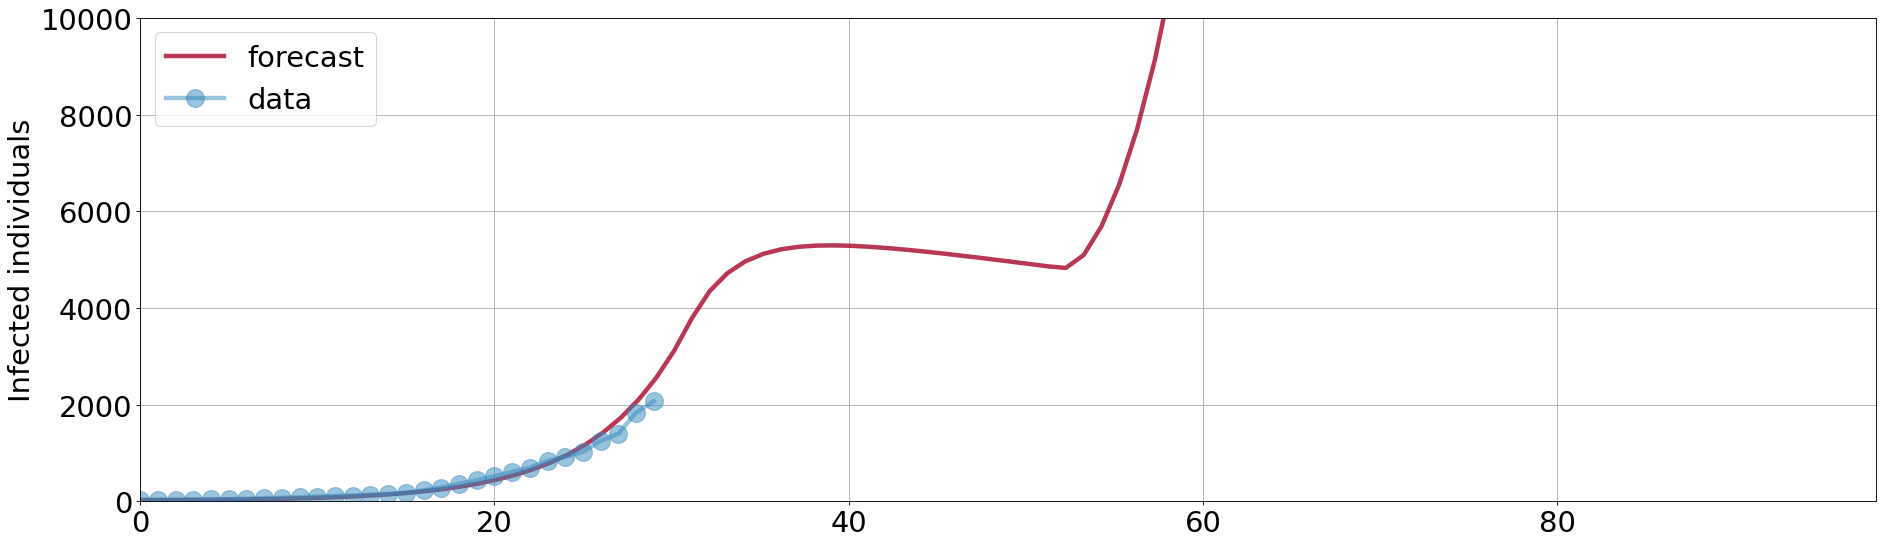

In [7]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,3*M+i] 
t = data['t']

fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)


my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=4)
day, cases = my_data[:,0], my_data[:,2]  


plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, 10000); plt.xlim(0, 98);

---

---

---